# Analyzing the MSTIS simulation

Included in this notebook:

* Opening files for analysis
* Rates, fluxes, total crossing probabilities, and condition transition probabilities
* Per-ensemble properties such as path length distributions and interface crossing probabilities
* Move scheme analysis
* Replica exchange analysis
* Replica move history tree visualization
* Replaying the simulation
* MORE TO COME! Like free energy projections, path density plots, and more

In [1]:
import logging
reload(logging)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info('Info logging activated')
init_log = logging.getLogger('openpathsampling.initialization')
init_log.setLevel(logging.CRITICAL)

INFO:root:Info logging activated


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

The optimum way to use storage depends on whether you're doing production or analysis. For analysis, you should open the file as an `AnalysisStorage` object. This makes the analysis much faster.

In [3]:
%%time
storage = paths.AnalysisStorage("mstis.nc")

INFO:openpathsampling.netcdfplus.netcdfplus:Open existing netCDF file 'mstis.nc' for reading - reading from existing file
INFO:openpathsampling.storage.storage:Cached all CVs in 350 ms
INFO:openpathsampling.storage.storage:Cache all objects of store `cvs` [3] in 15 ms
INFO:openpathsampling.storage.storage:Cache all objects of store `samples` [678] in 1297 ms
INFO:openpathsampling.storage.storage:Cache all objects of store `samplesets` [501] in 102 ms
INFO:openpathsampling.storage.storage:Cache all objects of store `volumes` [44] in 0 ms
INFO:openpathsampling.storage.storage:Cache all objects of store `ensembles` [155] in 0 ms
INFO:openpathsampling.storage.storage:Cache all objects of store `pathmovers` [89] in 258 ms
INFO:openpathsampling.storage.storage:Cache all objects of store `pathmovechanges` [2416] in 801 ms
INFO:openpathsampling.storage.storage:Cache all objects of store `steps` [501] in 172 ms


CPU times: user 3.13 s, sys: 150 ms, total: 3.28 s
Wall time: 3.27 s


In [4]:
mstis = storage.networks.load(0)

In [5]:
for store in storage.objects.values():
    print store.name, len(store.index), len(store), store.__class__.__name__

schemes 1 1 NamedObjectStore
[NamedObjectStore] 23 23 NamedObjectStore
snapshots 0 40756 SnapshotWrapperStore
tag 0 0 ImmutableDictStore
transitions 3 3 NamedObjectStore
networks 1 1 NamedObjectStore
ensembles 155 155 NamedObjectStore
engines 1 1 NamedObjectStore
topologies 1 1 NamedObjectStore
cv2 0 20378 SnapshotValueStore
pathmovers 89 89 NamedObjectStore
cv0 0 20378 SnapshotValueStore
cv1 0 20378 SnapshotValueStore
details 0 2880 ObjectStore
samples 678 678 SampleStore
trajectories 427 427 TrajectoryStore
snapshot0 20378 20378 FeatureSnapshotStore
pathmovechanges 2416 2416 PathMoveChangeStore
shootingpointselectors 8 8 NamedObjectStore
pathsimulators 1 1 NamedObjectStore
cvs 6 3 CVStore
steps 501 501 MCStepStore
volumes 44 44 NamedObjectStore
samplesets 501 501 SampleSetStore


## Reaction rates

TIS methods are especially good at determining reaction rates, and OPS makes it extremely easy to obtain the rate from a TIS network.

Note that, although you can get the rate directly, it is very important to look at other results of the sampling (illustrated in this notebook and in notebooks referred to herein) in order to check the validity of the rates you obtain.

By default, the built-in analysis calculates histograms the maximum value of some order parameter and the pathlength of every sampled ensemble. You can add other things to this list as well, but you must always specify histogram parameters for these two. The pathlength is in units of frames.

In [6]:
mstis.hist_args['max_lambda'] = { 'bin_width' : 0.02, 'bin_range' : (0.0, 0.5) }
mstis.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 150) }

In [7]:
cv = storage.cvs[0]

In [8]:
storage.trajectories[200]

Trajectory[30]

In [9]:
len(storage.snapshots.index)

1

In [10]:
len(storage.snapshot0)

20378

In [11]:
storage.trajectories.cache_all()

In [12]:
%%time
cv(storage.trajectories[378])

CPU times: user 3.54 ms, sys: 1.17 ms, total: 4.71 ms
Wall time: 3.91 ms


[0.039715124430000692,
 0.043382251808787409,
 0.046793265970078046,
 0.050018173211232586,
 0.053365011038356336,
 0.057245294924541668,
 0.061766190430782686,
 0.067268373180966456,
 0.072270173981639374,
 0.075788568543176282,
 0.078466251183081148,
 0.080734844667856187,
 0.082666373011332839,
 0.083704015928995901,
 0.084157953807612706,
 0.085107004088105898,
 0.086312451613240748,
 0.087506384502764156,
 0.090541527093352281,
 0.095050824806765633,
 0.099720385709822779,
 0.10569241071622049,
 0.1114411606376049,
 0.11598362889381875,
 0.11942704325907272,
 0.12083601628656915,
 0.12150056384160579,
 0.12256577013980174,
 0.12420803689839222,
 0.12531288892782655,
 0.12685346514718976,
 0.13010886823814083,
 0.13535769579100165,
 0.14220046178218326,
 0.14934181682597303,
 0.1568734057722212,
 0.1637878361936993,
 0.16977925843028402,
 0.17501836315331559,
 0.18008127160385717,
 0.18479040041482492,
 0.18943224819392146,
 0.19469868205391982,
 0.20003054099828543,
 0.20570990706

In [13]:
sum(map(len, storage.trajectories))

40057

In [14]:
q = storage.snapshots.all()

In [15]:
len(q)

40756

In [16]:
for cv in storage.cvs:
    print cv.diskcache_enabled

True
True
True


In [17]:
%%time
_ = cv(q)

CPU times: user 844 ms, sys: 108 ms, total: 952 ms
Wall time: 883 ms


In [18]:
%%time
cv[storage.snapshots.all()]

CPU times: user 281 ms, sys: 12.9 ms, total: 293 ms
Wall time: 286 ms


[1.0600000000000001,
 1.0600000000000001,
 0.85182323964243101,
 0.85182323964243101,
 0.8193499386493408,
 0.8193499386493408,
 0.78901349008658372,
 0.78901349008658372,
 0.76091450551810391,
 0.76091450551810391,
 0.7357715654440995,
 0.7357715654440995,
 0.71575804625320483,
 0.71575804625320483,
 0.69840946787531866,
 0.69840946787531866,
 0.68379505972009291,
 0.68379505972009291,
 0.67322688998054547,
 0.67322688998054547,
 0.66441939270030448,
 0.66441939270030448,
 0.65711095923490681,
 0.65711095923490681,
 0.64847739383602765,
 0.64847739383602765,
 0.63964279029339233,
 0.63964279029339233,
 0.6307645628674472,
 0.6307645628674472,
 0.62282038042868504,
 0.62282038042868504,
 0.616796812286447,
 0.616796812286447,
 0.61153372965521369,
 0.61153372965521369,
 0.6089001739177976,
 0.6089001739177976,
 0.60774805902298334,
 0.60774805902298334,
 0.60878847123142354,
 0.60878847123142354,
 0.61549213284853821,
 0.61549213284853821,
 0.62503961522297058,
 0.62503961522297058,
 0

In [19]:
len(storage.snapshots.cache)

1

In [20]:
%%time
mstis.rate_matrix(storage.steps, force=True)

INFO:openpathsampling.analysis.wham:iterations=114diff=8.9263929581e-11
INFO:openpathsampling.analysis.wham:       lnZ=[0.0, -1.2722783359633951, -3.9630370396277983]
INFO:openpathsampling.analysis.wham:iterations=43diff=8.73180416862e-11
INFO:openpathsampling.analysis.wham:       lnZ=[0.0, -0.9260669812233098, -1.0077461178396645]
INFO:openpathsampling.analysis.wham:iterations=35diff=9.02803387613e-11
INFO:openpathsampling.analysis.wham:       lnZ=[0.0, -0.36144315070601846, -1.1851494727317342]
INFO:openpathsampling.analysis.tis_analysis:Rate for C -> B
INFO:openpathsampling.analysis.tis_analysis:outer ensemble: I'face 2 <openpathsampling.ensemble.TISEnsemble object at 0x126467a10>
INFO:openpathsampling.analysis.tis_analysis:outer lambda: 0.16
INFO:openpathsampling.analysis.tis_analysis:CTP: 0/501=0.0

INFO:openpathsampling.analysis.tis_analysis:RATE = 0.0
INFO:openpathsampling.analysis.tis_analysis:flux * outer_tcp * ctp = 0.0218658892128 * 0.275740874005 * 0.0
INFO:openpathsampling

CPU times: user 2.73 s, sys: 82.7 ms, total: 2.81 s
Wall time: 2.76 s


,"{x|opA(x) in [0.0, 0.04]}","{x|opB(x) in [0.0, 0.04]}","{x|opC(x) in [0.0, 0.04]}"
"{x|opA(x) in [0.0, 0.04]}",NaN,0.000120083,0.00105072
"{x|opB(x) in [0.0, 0.04]}",3.84597e-05,NaN,0
"{x|opC(x) in [0.0, 0.04]}",0,0,NaN


In [21]:
%%time
for t in storage.trajectories:
    q = cv(t)

CPU times: user 517 ms, sys: 48.8 ms, total: 565 ms
Wall time: 531 ms


In [22]:
%%time
for s in storage.snapshots.all().as_proxies():
    cv(s)

CPU times: user 609 ms, sys: 98.3 ms, total: 708 ms
Wall time: 641 ms


In [23]:
%%time
ll = 0
for step in storage.steps:
    sset = step.active # take the sampleset after the move
    for sample in sset:
        ll += len(sample.trajectory)
#        print storage.idx(sample.ensemble),
        
        cv(sample)
        
print ll

765563
CPU times: user 2.58 s, sys: 14.1 ms, total: 2.6 s
Wall time: 2.59 s


In [24]:
%%prun
mstis.rate_matrix(storage.steps, force=True)

INFO:openpathsampling.analysis.wham:iterations=114diff=8.9263929581e-11
INFO:openpathsampling.analysis.wham:       lnZ=[0.0, -1.2722783359633951, -3.9630370396277983]
INFO:openpathsampling.analysis.wham:iterations=43diff=8.73180416862e-11
INFO:openpathsampling.analysis.wham:       lnZ=[0.0, -0.9260669812233098, -1.0077461178396645]
INFO:openpathsampling.analysis.wham:iterations=35diff=9.02803387613e-11
INFO:openpathsampling.analysis.wham:       lnZ=[0.0, -0.36144315070601846, -1.1851494727317342]
INFO:openpathsampling.analysis.tis_analysis:Rate for C -> B
INFO:openpathsampling.analysis.tis_analysis:outer ensemble: I'face 2 <openpathsampling.ensemble.TISEnsemble object at 0x126467a10>
INFO:openpathsampling.analysis.tis_analysis:outer lambda: 0.16
INFO:openpathsampling.analysis.tis_analysis:CTP: 0/501=0.0

INFO:openpathsampling.analysis.tis_analysis:RATE = 0.0
INFO:openpathsampling.analysis.tis_analysis:flux * outer_tcp * ctp = 0.0218658892128 * 0.275740874005 * 0.0
INFO:openpathsampling

The self-rates (the rate of returning the to initial state) are undefined, and return not-a-number.

The rate is calcuated according to the formula:

$$k_{AB} = \phi_{A,0} P(B|\lambda_m) \prod_{i=0}^{m-1} P(\lambda_{i+1} | \lambda_i)$$

where $\phi_{A,0}$ is the flux from state A through its innermost interface, $P(B|\lambda_m)$ is the conditional transition probability (the probability that a path which crosses the interface at $\lambda_m$ ends in state B), and $\prod_{i=0}^{m-1} P(\lambda_{i+1} | \lambda_i)$ is the total crossing probability. We can look at each of these terms individually.

### Total crossing probability

In [25]:
stateA = storage.volumes["A"]
stateB = storage.volumes["B"]
stateC = storage.volumes["C"]

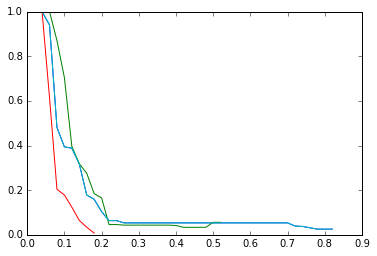

In [26]:
tcp_AB = mstis.transitions[(stateA, stateB)].tcp
tcp_AC = mstis.transitions[(stateA, stateC)].tcp
tcp_BC = mstis.transitions[(stateB, stateC)].tcp
tcp_BA = mstis.transitions[(stateB, stateA)].tcp
tcp_CA = mstis.transitions[(stateC, stateA)].tcp
tcp_CB = mstis.transitions[(stateC, stateB)].tcp

plt.plot(tcp_AB.x, tcp_AB)
plt.plot(tcp_CA.x, tcp_CA)
plt.plot(tcp_BC.x, tcp_BC)
plt.plot(tcp_AC.x, tcp_AC) # same as tcp_AB in MSTIS

We normally look at these on a log scale:

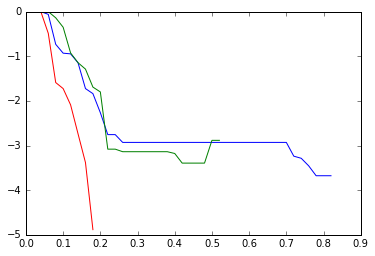

In [27]:
plt.plot(tcp_AB.x, np.log(tcp_AB))
plt.plot(tcp_CA.x, np.log(tcp_CA))
plt.plot(tcp_BC.x, np.log(tcp_BC))

### Flux

Here we also calculate the flux contribution to each transition. The flux is calculated based on 

In [28]:
import pandas as pd
flux_matrix = pd.DataFrame(columns=mstis.states, index=mstis.states)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    flux_matrix.set_value(state_pair[0], state_pair[1], transition._flux)

flux_matrix

,"{x|opA(x) in [0.0, 0.04]}","{x|opB(x) in [0.0, 0.04]}","{x|opC(x) in [0.0, 0.04]}"
"{x|opA(x) in [0.0, 0.04]}",NaN,0.028125,0.028125
"{x|opB(x) in [0.0, 0.04]}",0.0270062,NaN,0.0270062
"{x|opC(x) in [0.0, 0.04]}",0.0218659,0.0218659,NaN


### Conditional transition probability

In [29]:
outer_ctp_matrix = pd.DataFrame(columns=mstis.states, index=mstis.states)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    outer_ctp_matrix.set_value(state_pair[0], state_pair[1], transition.ctp[transition.ensembles[-1]])    

outer_ctp_matrix

,"{x|opA(x) in [0.0, 0.04]}","{x|opB(x) in [0.0, 0.04]}","{x|opC(x) in [0.0, 0.04]}"
"{x|opA(x) in [0.0, 0.04]}",NaN,0.0239521,0.209581
"{x|opB(x) in [0.0, 0.04]}",0.0419162,NaN,0
"{x|opC(x) in [0.0, 0.04]}",0,0,NaN


In [30]:
ctp_by_interface = pd.DataFrame(index=mstis.transitions)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    for ensemble_i in range(len(transition.ensembles)):
        ctp_by_interface.set_value(
            state_pair, ensemble_i,
            transition.conditional_transition_probability(
                storage.steps,
                transition.ensembles[ensemble_i]
        ))
    
    
ctp_by_interface  

INFO:openpathsampling.analysis.tis_analysis:CTP: 0/501=0.0

INFO:openpathsampling.analysis.tis_analysis:CTP: 0/501=0.0

INFO:openpathsampling.analysis.tis_analysis:CTP: 0/501=0.0

INFO:openpathsampling.analysis.tis_analysis:CTP: 30/501=0.059880239521

INFO:openpathsampling.analysis.tis_analysis:CTP: 25/501=0.0499001996008

INFO:openpathsampling.analysis.tis_analysis:CTP: 12/501=0.0239520958084

INFO:openpathsampling.analysis.tis_analysis:CTP: 0/501=0.0

INFO:openpathsampling.analysis.tis_analysis:CTP: 0/501=0.0

INFO:openpathsampling.analysis.tis_analysis:CTP: 105/501=0.209580838323

INFO:openpathsampling.analysis.tis_analysis:CTP: 0/501=0.0

INFO:openpathsampling.analysis.tis_analysis:CTP: 0/501=0.0

INFO:openpathsampling.analysis.tis_analysis:CTP: 0/501=0.0

INFO:openpathsampling.analysis.tis_analysis:CTP: 0/501=0.0

INFO:openpathsampling.analysis.tis_analysis:CTP: 0/501=0.0

INFO:openpathsampling.analysis.tis_analysis:CTP: 0/501=0.0

INFO:openpathsampling.analysis.tis_analysis:CTP: 

,0,1,2
"({x|opC(x) in [0.0, 0.04]}, {x|opB(x) in [0.0, 0.04]})",0.00000,0.000000,0.000000
"({x|opA(x) in [0.0, 0.04]}, {x|opB(x) in [0.0, 0.04]})",0.05988,0.049900,0.023952
"({x|opA(x) in [0.0, 0.04]}, {x|opC(x) in [0.0, 0.04]})",0.00000,0.000000,0.209581
"({x|opC(x) in [0.0, 0.04]}, {x|opA(x) in [0.0, 0.04]})",0.00000,0.000000,0.000000
"({x|opB(x) in [0.0, 0.04]}, {x|opC(x) in [0.0, 0.04]})",0.00000,0.000000,0.000000
"({x|opB(x) in [0.0, 0.04]}, {x|opA(x) in [0.0, 0.04]})",0.00000,0.005988,0.041916


## Path ensemble properties

In [31]:
hists_A = mstis.transitions[(stateA, stateB)].histograms
hists_B = mstis.transitions[(stateB, stateC)].histograms
hists_C = mstis.transitions[(stateC, stateB)].histograms

### Interface crossing probabilities

We obtain the total crossing probability, shown above, by combining the individual crossing probabilities of 

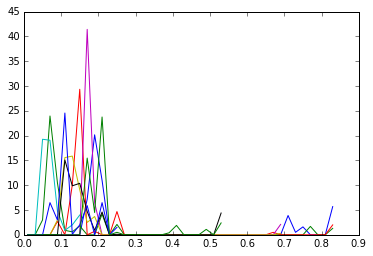

In [32]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        normalized = hist['max_lambda'][ens].normalized()
        plt.plot(normalized.x, normalized)

In [33]:
# add visualization of the sum

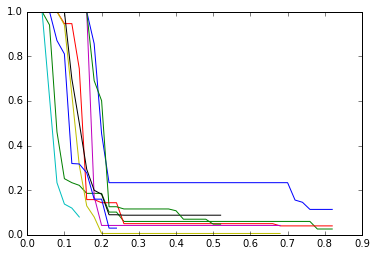

In [34]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        reverse_cumulative = hist['max_lambda'][ens].reverse_cumulative()
        plt.plot(reverse_cumulative.x, reverse_cumulative)

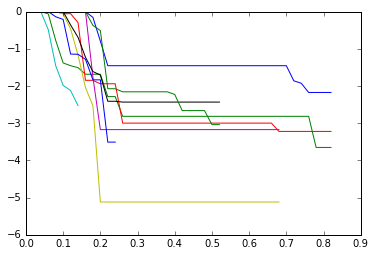

In [35]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        reverse_cumulative = hist['max_lambda'][ens].reverse_cumulative()
        plt.plot(reverse_cumulative.x, np.log(reverse_cumulative))

### Path length histograms

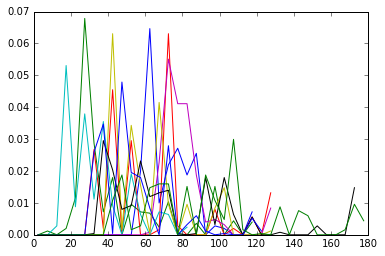

In [36]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['pathlength']:
        normalized = hist['pathlength'][ens].normalized()
        plt.plot(normalized.x, normalized)

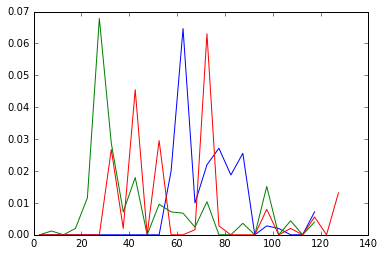

In [37]:
for ens in hists_A['pathlength']:
    normalized = hists_A['pathlength'][ens].normalized()
    plt.plot(normalized.x, normalized)

## Sampling properties

The properties we illustrated above were properties of the path ensembles. If your path ensembles are sufficiently well-sampled, these will never depend on how you sample them.

But to figure out whether you've done a good job of sampling, you often want to look at properties related to the sampling process. OPS also makes these very easy.

### Move scheme analysis

In [38]:
scheme = storage.schemes[0]

In [39]:
scheme.move_summary(storage.steps)

ms_outer_shooting ran 5.800% (expected 4.98%) of the cycles with acceptance 22/29 (75.86%)
repex ran 21.000% (expected 22.39%) of the cycles with acceptance 29/105 (27.62%)
shooting ran 45.200% (expected 44.78%) of the cycles with acceptance 178/226 (78.76%)
minus ran 4.000% (expected 2.99%) of the cycles with acceptance 19/20 (95.00%)
pathreversal ran 24.000% (expected 24.88%) of the cycles with acceptance 115/120 (95.83%)


In [40]:
scheme.move_summary(storage.steps, 'shooting')

OneWayShootingMover I'face 0 ran 6.600% (expected 4.98%) of the cycles with acceptance 25/33 (75.76%)
OneWayShootingMover I'face 0 ran 5.200% (expected 4.98%) of the cycles with acceptance 26/26 (100.00%)
OneWayShootingMover I'face 2 ran 5.400% (expected 4.98%) of the cycles with acceptance 17/27 (62.96%)
OneWayShootingMover I'face 0 ran 4.000% (expected 4.98%) of the cycles with acceptance 17/20 (85.00%)
OneWayShootingMover I'face 1 ran 3.600% (expected 4.98%) of the cycles with acceptance 14/18 (77.78%)
OneWayShootingMover I'face 2 ran 4.400% (expected 4.98%) of the cycles with acceptance 14/22 (63.64%)
OneWayShootingMover I'face 1 ran 4.600% (expected 4.98%) of the cycles with acceptance 18/23 (78.26%)
OneWayShootingMover I'face 1 ran 6.200% (expected 4.98%) of the cycles with acceptance 27/31 (87.10%)
OneWayShootingMover I'face 2 ran 5.200% (expected 4.98%) of the cycles with acceptance 20/26 (76.92%)


In [41]:
scheme.move_summary(storage.steps, 'minus')

Minus ran 0.600% (expected 1.00%) of the cycles with acceptance 3/3 (100.00%)
Minus ran 1.800% (expected 1.00%) of the cycles with acceptance 9/9 (100.00%)
Minus ran 1.600% (expected 1.00%) of the cycles with acceptance 7/8 (87.50%)


In [42]:
scheme.move_summary(storage.steps, 'repex')

ReplicaExchange ran 3.600% (expected 2.49%) of the cycles with acceptance 7/18 (38.89%)
ReplicaExchange ran 2.600% (expected 2.49%) of the cycles with acceptance 0/13 (0.00%)
ReplicaExchange ran 1.600% (expected 2.49%) of the cycles with acceptance 2/8 (25.00%)
ReplicaExchange ran 3.800% (expected 2.49%) of the cycles with acceptance 5/19 (26.32%)
ReplicaExchange ran 1.200% (expected 2.49%) of the cycles with acceptance 0/6 (0.00%)
ReplicaExchange ran 2.000% (expected 2.49%) of the cycles with acceptance 3/10 (30.00%)
ReplicaExchange ran 2.200% (expected 2.49%) of the cycles with acceptance 10/11 (90.91%)
ReplicaExchange ran 1.400% (expected 2.49%) of the cycles with acceptance 0/7 (0.00%)
ReplicaExchange ran 2.600% (expected 2.49%) of the cycles with acceptance 2/13 (15.38%)


In [43]:
scheme.move_summary(storage.steps, 'pathreversal')

PathReversal ran 2.600% (expected 2.49%) of the cycles with acceptance 13/13 (100.00%)
PathReversal ran 2.400% (expected 2.49%) of the cycles with acceptance 12/12 (100.00%)
PathReversal ran 1.400% (expected 2.49%) of the cycles with acceptance 7/7 (100.00%)
PathReversal ran 2.000% (expected 2.49%) of the cycles with acceptance 10/10 (100.00%)
PathReversal ran 3.000% (expected 2.49%) of the cycles with acceptance 15/15 (100.00%)
PathReversal ran 3.800% (expected 2.49%) of the cycles with acceptance 19/19 (100.00%)
PathReversal ran 3.200% (expected 2.49%) of the cycles with acceptance 12/16 (75.00%)
PathReversal ran 1.800% (expected 2.49%) of the cycles with acceptance 9/9 (100.00%)
PathReversal ran 1.200% (expected 2.49%) of the cycles with acceptance 6/6 (100.00%)
PathReversal ran 2.600% (expected 2.49%) of the cycles with acceptance 12/13 (92.31%)


### Replica exchange sampling

See the notebook `repex_networks.ipynb` for more details on tools to study the convergence of replica exchange. However, a few simple examples are shown here. All of these are analyzed with a separate object, `ReplicaNetwork`.

In [44]:
repx_net = paths.ReplicaNetwork(scheme, storage.steps)

#### Replica exchange mixing matrix

In [45]:
repx_net.mixing_matrix()

,12,6,7,8,10,3,4,5,11,0,1,2,9
12,0.000,0.024,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
6,0.024,0.000,0.080,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
7,0.000,0.080,0.000,0.056,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
8,0.000,0.000,0.056,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
10,0.000,0.000,0.000,0.000,0.000,0.072,0.000,0.000,0.000,0.000,0.000,0.000,0.0
3,0.000,0.000,0.000,0.000,0.072,0.000,0.024,0.000,0.000,0.000,0.000,0.000,0.0
4,0.000,0.000,0.000,0.000,0.000,0.024,0.000,0.016,0.000,0.000,0.000,0.000,0.0
5,0.000,0.000,0.000,0.000,0.000,0.000,0.016,0.000,0.000,0.000,0.000,0.000,0.0
11,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.056,0.000,0.000,0.0
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.056,0.000,0.040,0.000,0.0


#### Replica exchange graph

The mixing matrix tells a story of how well various interfaces are connected to other interfaces. The replica exchange graph is essentially a visualization of the mixing matrix (actually, of the transition matrix -- the mixing matrix is a symmetrized version of the transition matrix).

Note: We're still developing better layout tools to visualize these.

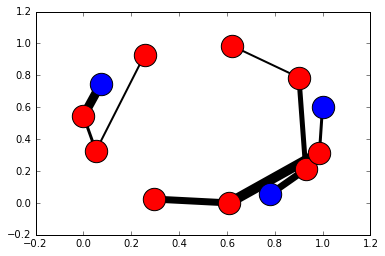

In [46]:
repxG = paths.ReplicaNetworkGraph(repx_net)
repxG.draw('spring')

#### Replica exchange flow

Replica flow is defined as ***TODO***

Flow is designed for calculations where the replica exchange graph is linear, which ours clearly is not. However, we can define the flow over a subset of the interfaces.

### Replica move history tree

In [48]:
import openpathsampling.visualize as vis
reload(vis)
from IPython.display import SVG

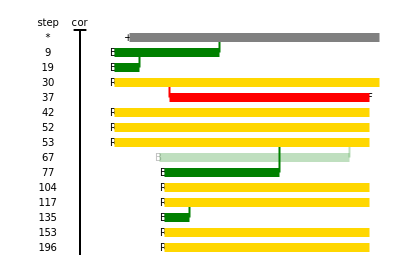

In [49]:
tree = vis.PathTree(
    storage.steps[0:200],
    vis.ReplicaEvolution(replica=2, accepted=False)
)

# print [s.mover for s in tree.samples]

SVG(tree.svg())

In [67]:
t1 = list(tree.samples)[2].trajectory

In [72]:
t2 = list(tree.samples)[4].trajectory 

In [71]:
len(list(tree.samples))

27

In [77]:
storage.snapshots.index.get(t1[0])

4562

In [79]:
storage.snapshots.index.get(t2[-1].reversed)

In [50]:
decorrelated = tree.generator.decorrelated
print "We have " + str(len(decorrelated)) + " decorrelated trajectories."

We have 9 decorrelated trajectories.


### Visualizing trajectories

In [51]:
from toy_plot_helpers import ToyPlot
background = ToyPlot()
background.contour_range = np.arange(-1.5, 1.0, 0.1)
background.add_pes(storage.engines[0].pes)

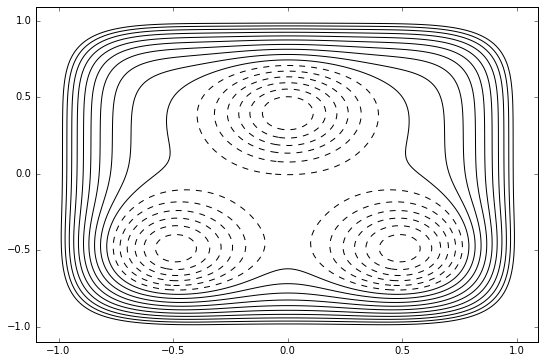

In [52]:
xval = paths.CV_Function("xval", lambda snap : snap.xyz[0][0])
yval = paths.CV_Function("yval", lambda snap : snap.xyz[0][1])
live_vis = paths.LiveVisualization(mstis, xval, yval, [-1.0, 1.0], [-1.0, 1.0])
live_vis.background = background.plot()

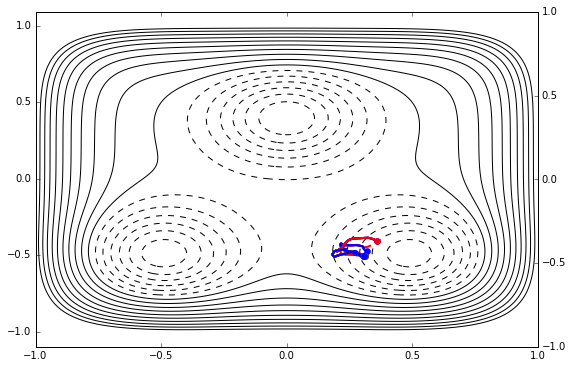

In [53]:
live_vis.draw_samples(list(tree.samples))

## Histogramming data (TODO)

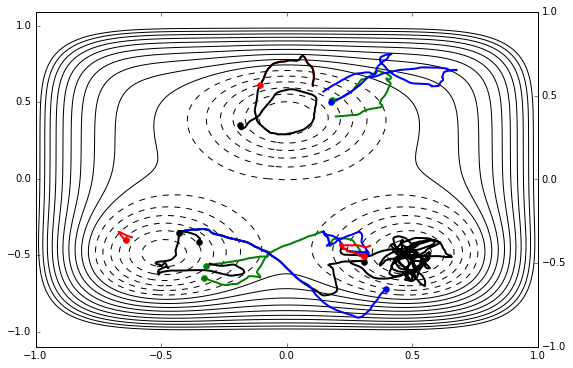

In [54]:
#! skip
# The skip directive tells our test runner not to run this cell
import time
max_step = 10
for step in storage.steps[0:max_step]:
    live_vis.draw_ipynb(step)
    time.sleep(0.1)